# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [2]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

![title](D:\GoogleDrive\retina\Chou's data\20210504\FIG\cSTA\fitNGD2Lparameter.tiff)

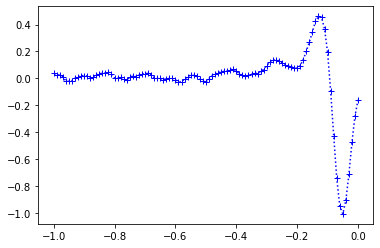

In [3]:
fig, ax = plt.subplots()
dt = 0.01
x_list, T_list, rstate_list = expSnR(['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_cSTA_sort_unit2.mat']
                                     , dt, 'LED', np.arange(60)+1)
x = x_list[0]
x = x-np.mean(x)
cn = 53-1
rstate = rstate_list[0][cn,:]
cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
ax.plot(taxis, cSTA, 'b+:')

# NGD1L

In [4]:
def NGD_TK(T, alpha, beta, g,  tau_y, Amp, ds=50):
    dt = np.mean(np.diff(T))
    dt = dt/ds
    T = np.arange(0, T[-1]+dt, dt)
    if tau_y == 0:
        x = np.zeros_like(T)
        x[0] = 1
    else:
        x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + -x[j]-z[j] )
        dz=dt*(-beta *z[j]  + g*y[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return Amp*y[::ds]/(dt) #normalized by integration

In [5]:
def NGD_TK_ND(T, alpha, beta, g,  Amp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)

    x = np.zeros_like(T)
    x[0] = 1
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + -x[j]-z[j] )
        dz=dt*(-beta *z[j]  + g*y[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return Amp*y[::50]/(dt) #normalized by integration

In [6]:
def NGD_TK_AS(T, epsilon, omegastar, deltastar, tau_y, Bmp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):10]

epsilon  : 13.929660930452242
omegastar: 44.48570854556918
deltastar: 0.3075912269497052
tau_y    : 0.0720106045193598
Bmp      : 18.14214565978881


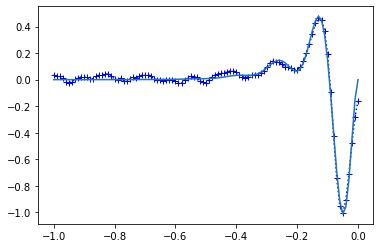

In [7]:
epsilon  = 10
omegastar= 32
deltastar= 0.
tau_y    = 0.06
Bmp      = 17

popt,pcov = curve_fit(NGD_TK_AS, np.abs(taxis) , cSTA, p0=[epsilon, omegastar, deltastar, tau_y, Bmp],
                      bounds = ([0     , 0     , 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, 0.6   , np.inf]) )
[epsilon, omegastar, deltastar, tau_y, Bmp] = popt
print('epsilon  :',epsilon)
print('omegastar:',omegastar)
print('deltastar:',deltastar)
print('tau_y    :',tau_y)
print('Bmp      :',Bmp)
fit_cSTA = NGD_TK_AS(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

In [8]:
alpha = epsilon+omegastar*np.tan(deltastar)
beta  = epsilon-omegastar*np.tan(deltastar)
g     = omegastar**2*(1+np.tan(deltastar)**2)
tau_y = tau_y
Amp   = Bmp*np.cos(deltastar)
print('alpha:',alpha)
print('beta :',beta)
print('g    :',g)
print('tau_y:',tau_y)
print('Amp  :',Amp)

alpha: 28.06159660753788
beta : -0.20227474663339784
g    : 2178.689870782613
tau_y: 0.0720106045193598
Amp  : 17.290655362872712


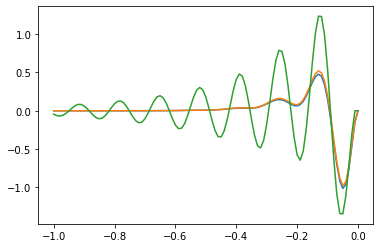

In [9]:
plt.plot(taxis, fit_cSTA)
plt.plot(taxis, NGD_TK(np.abs(taxis), alpha, beta, g,  tau_y, Amp))
plt.plot(taxis, NGD_TK(np.abs(taxis), alpha, beta, g,  tau_y, Amp, 1))

# NoDelay 

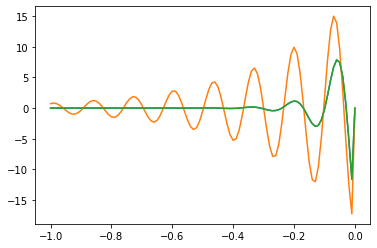

In [10]:
plt.plot(taxis, NGD_TK(np.abs(taxis), alpha, beta, g,  0, Amp))
TKnd_ds1 = NGD_TK(np.abs(taxis), alpha, beta, g,  0, Amp, 1)
plt.plot(taxis, TKnd_ds1)
plt.plot(taxis, NGD_TK_ND(np.abs(taxis), alpha, beta, g,  Amp))

alpha: -4.299935500175209
beta : 11.077841970302199
g    : 2331.8341452629097
Amp  : 18.474484704226363


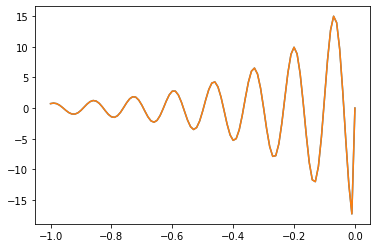

In [11]:
plt.plot(taxis, TKnd_ds1)

popt,pcov = curve_fit(NGD_TK_ND, np.abs(taxis) , TKnd_ds1, p0=[alpha, beta, g,  Amp])
[alpha, beta, g,  Amp] = popt
print('alpha:',alpha)
print('beta :',beta)
print('g    :',g)
# print('tau_y:',tau_y)
print('Amp  :',Amp)
fit_cSTA = NGD_TK_ND(np.abs(taxis), *popt).copy()
plt.plot(taxis, fit_cSTA)